In [102]:
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import dataLoader as dl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import util as ut

#from Inner_Speech_Dataset.Plotting.ERPs import 
from Inner_Speech_Dataset.Python_Processing.Data_extractions import  Extract_data_from_subject
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Calculate_power_windowed
from Inner_Speech_Dataset.Python_Processing.Utilitys import picks_from_channels
from Inner_Speech_Dataset.Python_Processing.Data_processing import Average_in_frec

In [103]:


sampling_rate = 256
nr_of_datasets=1
data, labels = dl.load_multiple_datasets(nr_of_datasets=nr_of_datasets, sampling_rate=sampling_rate, t_min=2, t_max=3, twoDLabels=True)

ch_names = ut.get_channelNames()

print(data.shape)
data_p =  ut.get_power_array(data[:,:128,:], sampling_rate, trialSplit=1).squeeze()
print(data_p.shape)
#print(data_p[:,:,1])

#Getting Freq Data 
nr_of_buckets = 15
buckets = ut.createFreqBuckets(data[:,:128,:], nr_of_buckets)

#buckets = np.reshape(np.linspace(0,50,nr_of_buckets*2),[nr_of_buckets, -1])
#buckets = np.array([[0,3],[4,8],[9,15],[16,34],[35,45],[45,80]])
nr_of_buckets = buckets.shape[0]
print("buckets")
print(buckets)
data_f = ut.data_into_freq_buckets(data[:,:128,:], nr_of_buckets, buckets)
data_f = data_f[:,:, [11 , 6 , 2 , 4]]
#data_f = np.concatenate([dataf, np.zeros([data_f.shape[0], nr_of_datasets, data_f.shape[2]])], axis=1)

print(data_f.shape)


## Normalize data



Data shape: [trials x channels x samples]
(500, 128, 256)
Labels shape
(500, 4)
Final data shape
(100, 128, 256)
Final labels shape
(100,)
Up is 0.0 and Down is 1.0
(100, 128, 256)
(100, 128, 2)
buckets
[[  0   2]
 [  2   5]
 [  5   8]
 [  8  12]
 [ 12  16]
 [ 16  21]
 [ 21  28]
 [ 28  36]
 [ 36  47]
 [ 47  60]
 [ 60  77]
 [ 76  94]
 [ 91 112]
 [ 67  79]
 [  3   4]]
(100, 128, 4)


In [104]:
#from scipy.fft import rfft, ifft, fftshift, fftfreq
#fftfreq(data.shape[2],1/data.shape[2])
import seaborn as sn
dataFFTCV = np.array(ut.fftCovariance(data))




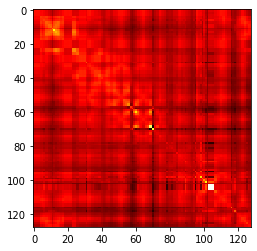

In [105]:
#plt.plot(dataFFTCV[2])
plt.imshow(dataFFTCV[2], cmap="hot", interpolation="nearest")
plt.show()

In [106]:
print(data_f.shape)
print(data_p.shape)
print(labels.shape)
print(data_p[2,5])

#data = np.concatenate([data_f, data_p], axis =2 ) #, data
data = dataFFTCV
print(data.shape)
data = keras.utils.normalize(data, axis=1, order=2)
print(data.shape)
#print(data[2,5])
#print(labels[2])
print(labels[:].shape)

(100, 128, 4)
(100, 128, 2)
(100, 2)
[9.56732240e-11 4.90024352e-11]
(100, 128, 128)
(100, 128, 128)
(100, 2)


In [107]:
#Add end of ekg with specific array for each person. 


In [108]:
#Splitting into training and test data
#print(labels)


order = np.arange(labels.shape[0])
np.random.shuffle(order)

temp_data = np.zeros(data.shape)
temp_labels = np.zeros(labels.shape)

for x in range(labels.shape[0]):
    i = order[x]
    
    temp_data[x] = data[i]
    temp_labels[x] = labels[i]

data = temp_data
labels = temp_labels

data_train, data_test = np.split(data, indices_or_sections=[int(labels.shape[0]*0.75)],axis=0)
labels_train, labels_test = np.split(labels, indices_or_sections=[int(labels.shape[0]*0.75)],axis=0)
print(labels_train.shape)
print(data_train.shape)
print(data_test.shape)




(75, 2)
(75, 128, 128)
(25, 128, 128)


In [109]:
# #!pip3 install sklearn -q
# from tabnanny import verbose
# from sklearn.svm import SVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.metrics import classification_report

# def svmPipeline(data_train, data_test, labels_train,
#     labels_test, kernel="linear", degree=3, gamma="auto", C = 1
#     , coefs = np.zeros([1, data_train.shape[1]*data_train.shape[2]])):
    
#     anova_filter = SelectKBest(f_classif, k=25)
#     clf = make_pipeline(anova_filter, StandardScaler() ,  SVC(
#         gamma=gamma, kernel=kernel, degree=degree, verbose=False, C=C))

#     clf.fit(np.reshape(data_train, [data_train.shape[0], -1]), labels_train)
#     predictions = clf.predict(np.reshape(data_test, [data_test.shape[0], -1]))
    
#     print(classification_report(labels_test, predictions))
#     if kernel == "linear":
#         coefs = coefs + clf[:-1].inverse_transform(clf[-1].coef_)
#     #print(clf[:-1].inverse_transform(clf[-1].coef_).shape)

#     correct = np.zeros(labels_test.shape)
#     correctamount=0
#     for nr, pred in enumerate(predictions,0):
#         if pred == labels_test[nr]:
#             correct[nr] = 1
#             correctamount +=1


#     return correctamount/labels_test.shape[0], coefs

# #testing using different kernels, C and degrees. 
# coefs = np.zeros([1, data_train.shape[1]*data_train.shape[2]])
# for kernel in ["linear", "rbf", "sigmoid"]:

#     for C in np.linspace(0.2,1,5):
    
#         if kernel == "linear":
#             for degree in range(1,3):
#                 res, coefs = svmPipeline(data_train, data_test, labels_train, 
#                 labels_test, degree=degree, kernel = kernel, C = C, coefs=coefs)
#                 print("Result for degree {}, kernel {}, C = {}: {}".format(degree, kernel, C,  res))
#         # else:
#         #     for gamma in ["auto", "scale"]:

#         #         res = svmPipeline(data_train, data_test, labels_train, 
#         #         labels_test, degree=degree, kernel = kernel, gamma=gamma, C = C)
#         #         print("Result for gamma {}, kernel {}, C = {}: {}".format(gamma, kernel, C, res))

# coefs = np.reshape(coefs, [128,-1])

In [110]:
# #Checks which frequency buckets are most valuable
# def coefFeatureCheck(coefs, buckets):
#     for x in range(buckets.shape[0], buckets.shape[0] + 2):
#         print("Power feature bin {} has value {} ".format(x-buckets.shape[0], np.sum(coefs[:,x])))

#     freqBins = np.zeros(buckets.shape[0])
#     for x in range(0,buckets.shape[0]):
#         # #print(np.sum(coefs[:,0]))
#         freqBins [x] = np.sum(coefs[:,x])
#         print("Frequency bin {} has feature value of {}".format(buckets[x], np.sum(coefs[:,x])))

#     channelBins = np.zeros(coefs.shape[0])
#     for x in range(0, coefs.shape[0]):
#         #print(np.sum(coefs[:,0]))
#         if  np.sum(coefs[x,:]) == 0:
#             continue
#         channelBins[x] = np.sum(coefs[x,:])
#         print("Channel bin {} has feature value of {}".format(x, np.sum(coefs[x,:])))

#     #print(channelBins)
#     #print(freqBins)
#     print(buckets[np.argpartition(freqBins, -4)[-4:]])
#     return np.argpartition(freqBins, -4)[-4:]
# mostUsefulFreqBuckets =  coefFeatureCheck(coefs, buckets)
# print(mostUsefulFreqBuckets)



In [180]:

print("Works for 1 subject data, 64 percent acc?")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

tf.keras.backend.clear_session()





eeg_model = tf.keras.Sequential([

    # layers.LocallyConnected1D(50, input_shape = (1, data_train.shape[1]), 
    #  kernel_size=15, 
    #  padding="valid", strides=1,
    #  activation="relu"),

    # layers.Dropout(0.4),
    
    # layers.LocallyConnected1D(30, 
    # kernel_size=15, 
    # padding="valid", strides=1,
    # activation="relu"),
    
    # layers.Dropout(0.4),
    
    #layers.Flatten(input_shape = data_train.shape[1]),
    layers.LocallyConnected2D(20, [10,10], 10, 
    input_shape=(data_train.shape[1], data_train.shape[2], 1),

    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5)

    ),

    layers.Dropout(0.5),

    layers.LocallyConnected2D(20, [2,2], 2, 
    input_shape=(data_train.shape[1], data_train.shape[2], 1),
    
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5)
    
    ),
    layers.Dropout(0.5),

    layers.Dense(units=500, activation="relu",
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5)
    
    ),

    layers.Dropout(0.8),

    layers.Flatten(),

    layers.Dense(units=2, activation="softmax")


])
eeg_model.build()
eeg_model.summary()



Works for 1 subject data, 64 percent acc?
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 locally_connected2d (Locall  (None, 12, 12, 20)       290880    
 yConnected2D)                                                   
                                                                 
 dropout (Dropout)           (None, 12, 12, 20)        0         
                                                                 
 locally_connected2d_1 (Loca  (None, 6, 6, 20)         58320     
 llyConnected2D)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 20)          0         
                                                                 
 dense (Dense)               (None, 6, 6, 500)         10500     
                                                                 
 dropout_2 (Dr

In [178]:

# print("Works for 1 subject data, 64 percent acc")
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, regularizers

# tf.keras.backend.clear_session()





# eeg_model = tf.keras.Sequential([

#     # layers.LocallyConnected1D(50, input_shape = (1, data_train.shape[1]), 
#     #  kernel_size=15, 
#     #  padding="valid", strides=1,
#     #  activation="relu"),

#     # layers.Dropout(0.4),
    
#     # layers.LocallyConnected1D(30, 
#     # kernel_size=15, 
#     # padding="valid", strides=1,
#     # activation="relu"),
    
#     # layers.Dropout(0.4),
    
#     #layers.Flatten(input_shape = data_train.shape[1]),
#     layers.LocallyConnected2D(50, [10,10], 10, 
#     input_shape=(data_train.shape[1], data_train.shape[2], 1)
#     ),

#     layers.Dropout(0.3),

#     layers.LocallyConnected2D(50, [2,2], 2, 
#     input_shape=(data_train.shape[1], data_train.shape[2], 1)
    
    
#     ,kernel_regularizer=regularizers.L1L2(l1=2e-5, l2=2e-4),
#     bias_regularizer=regularizers.L2(2e-4),
#     activity_regularizer=regularizers.L2(2e-5)
    
#     ),
#     layers.Dropout(0.4),
#     layers.Dense(units=500, activation="relu"
#     ,kernel_regularizer=regularizers.L1L2(l1=2e-5, l2=2e-4),
#     bias_regularizer=regularizers.L2(2e-4),
#     activity_regularizer=regularizers.L2(2e-5)
    
    
#     ),

#     layers.Dropout(0.5),

#     layers.Flatten(),

#     layers.Dense(units=2, activation="softmax")


# ])
# eeg_model.build()
# eeg_model.summary()



Works for 1 subject data, 64 percent acc
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 locally_connected2d (Locall  (None, 12, 12, 50)       727200    
 yConnected2D)                                                   
                                                                 
 dropout (Dropout)           (None, 12, 12, 50)        0         
                                                                 
 locally_connected2d_1 (Loca  (None, 6, 6, 50)         361800    
 llyConnected2D)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 50)          0         
                                                                 
 dense (Dense)               (None, 6, 6, 500)         25500     
                                                                 
 dropout_2 (Dro

Results
1/1 [==============================] - 1s 748ms/step


<Figure size 432x288 with 0 Axes>

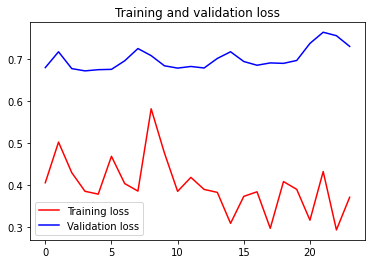

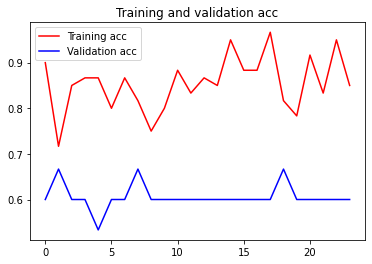

<Figure size 432x288 with 0 Axes>

In [182]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
#callback2 = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
#tensorboard_callback = tf.keras.callbacks.TensorBoard(histogram_freq=2)

eeg_model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

data_train_send = np.reshape(data_train, [data_train.shape[0], data_train.shape[1], data_train.shape[2], 1])
#data_train_send = np.reshape(data_train, [data_train.shape[0], 1 , data_train.shape[1], data_train.shape[2], 1])

data_test_send = np.reshape(data_test, [data_test.shape[0], data_test.shape[1], data_test.shape[2], 1])
#data_test_send = np.reshape(data_test, [data_test.shape[0], 1 , data_test.shape[1], data_test.shape[2], 1])

outputs = eeg_model.fit(data_train_send, labels_train, validation_split=0.2 ,callbacks=[callback], epochs=200, verbose=False) #

print("Results")
eeg_model.evaluate(data_test_send, labels_test)
result = eeg_model.predict(data_test_send)



val_loss = outputs.history["val_loss"]
loss = outputs.history["loss"]
#epochs = eeg_model.history.history["val_loss"]
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

val_acc = outputs.history["val_accuracy"]
acc = outputs.history["accuracy"]
plt.plot(acc, 'r', label='Training acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.figure()



In [114]:

eeg_model.save('saved_model/my_model6')

INFO:tensorflow:Assets written to: saved_model/my_model6\assets


In [115]:
print("Results")
eeg_model.evaluate(data_test, labels_test)
result = eeg_model.predict(data_test)

result2 = []
print(result)
for res in result:
    x = np.maximum(res[0], res[1])
    result2.append(int(np.where(res == x)[0]))

result2 = np.array(result2)
print(result2)

Results


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/locally_connected2d/strided_slice' defined at (most recent call last):
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_22064\2286269365.py", line 2, in <cell line: 2>
      eeg_model.evaluate(data_test, labels_test)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\layers\locally_connected\locally_connected2d.py", line 336, in call
      output = backend.local_conv(
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\backend.py", line 6631, in local_conv
      xs.append(reshape(inputs[slices], (1, -1, feature_dim)))
Node: 'sequential/locally_connected2d/strided_slice'
Index out of range using input dim 3; input has only 3 dims
	 [[{{node sequential/locally_connected2d/strided_slice}}]] [Op:__inference_test_function_340149]